
Table of Contents

- [Download OSM street network data](#download)

- [Calculate network centrality measures](#centrality)

- [Calculate shortest paths](#path)
- [Service area](#sa)

`networkx` is a python package for handling generic networks (https://networkx.org).

`osmnx` is a python package to retrieve, model, analyze, and visualize OpenStreetMap street networks and other spatial data (https://github.com/gboeing/osmnx).

`osmnx` is built upon `networkx` for easily accessing and processing OSM data.

There are several example notebooks demostrating the utility of the `osmnx` package: https://github.com/gboeing/osmnx-examples/tree/master/notebooks

In [1]:
#!pip install osmnx --upgrade #Comment this out once updated
import osmnx as ox
import networkx as nx
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

Requirement already up-to-date: osmnx in /Users/ziqi/opt/anaconda3/lib/python3.7/site-packages (1.0.1)


/Users/ziqi/opt/anaconda3/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


<a id='download'></a>

`ox.graph_from_place()` is a function for downloading OSM data for a specific place and for a specific network_type.

There are several supported network_type parameters: 'walk', 'bike', 'drive', 'drive_service', 'all', or 'all_private'

In [2]:
#It may take a while depending on the size of your area.
G_c = ox.graph_from_place('Champaign, Illinois, USA', network_type='drive')


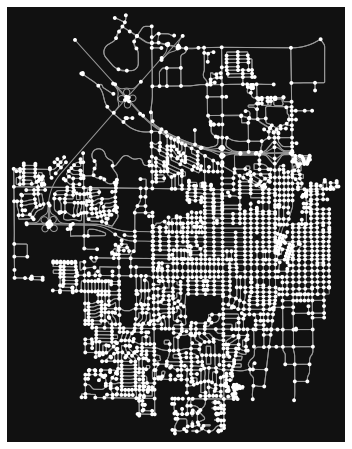

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [3]:
ox.plot_graph(G_c) #Plotting a network

In [4]:
G_u = ox.graph_from_place('Urbana, Illinois, USA', network_type='drive')

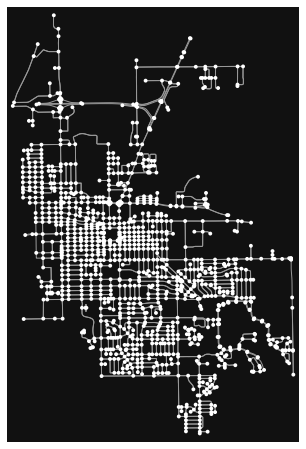

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [5]:
ox.plot_graph(G_u)

We can merge the two cities by:

In [6]:
G = nx.compose(G_c,G_u) #Merge Champaign with Urbana

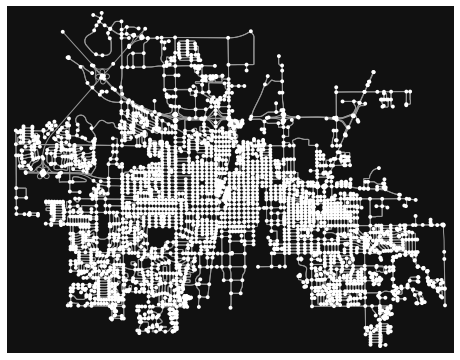

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [7]:
ox.plot_graph(G)

Alternatively, you can get the data from a bounding box where you need to define the coordinates of the four corners.

In [8]:
#bbox order: north, south, east, west
G_bb = ox.graph_from_bbox(40.1555,40.0300, -88.1663, -88.3026, network_type='drive')

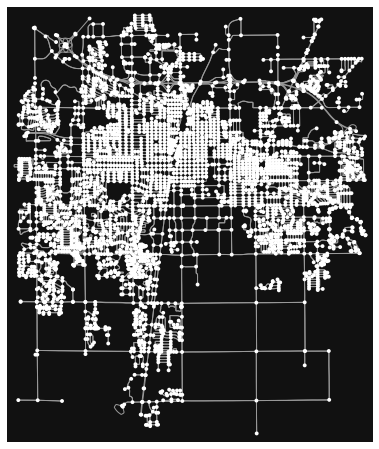

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [9]:
ox.plot_graph(G_bb)

Another way of retreiving data is using a coordinate with a buffer distance. Here I'm using a 2000-meter buffer from the center of UIUC.

In [10]:
G_buffer = ox.graph_from_point((40.107450,-88.227312), dist=2000, dist_type='network')


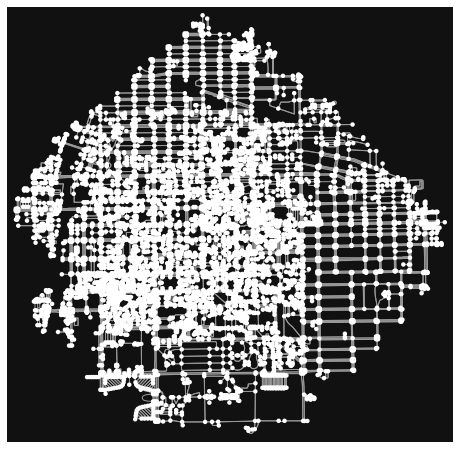

In [11]:
fig, ax = ox.plot_graph(G_buffer,node_size=5)

Another possible useful function is `ox.geocode_to_gdf()` which can be used to retrieve a boundary file. Note that you got part of the lake there.

<AxesSubplot:>

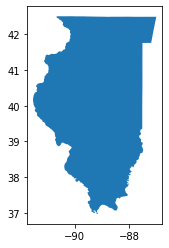

In [12]:
place_name = ['Illinois, USA']

IL = ox.geocode_to_gdf(place_name)

IL.plot()

<a id='centrality'></a>

### Centrality
- Degree centrality
- Betweenness centrality
- Closeness centrality

Degree centrality

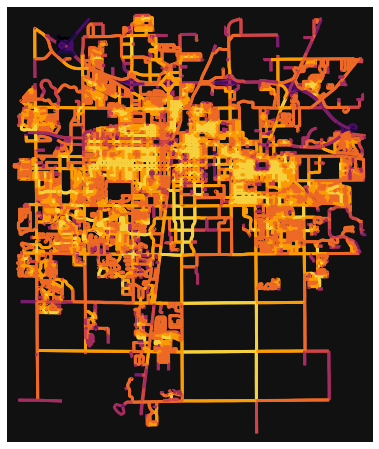

In [13]:
degree_centrality = nx.degree_centrality(nx.line_graph(G_bb))

nx.set_edge_attributes(G_bb, degree_centrality, 'degree_centrality')
 
ec = ox.plot.get_edge_colors_by_attr(G_bb, 'degree_centrality', cmap='inferno')

fig, ax = ox.plot_graph(G_bb, edge_color=ec, edge_linewidth=3, node_size=0)

Betweenness centrality

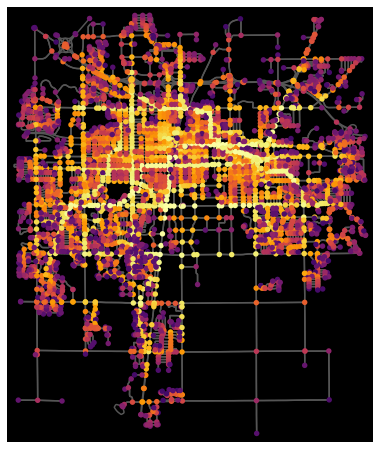

In [14]:
bt_centrality = nx.betweenness_centrality(nx.DiGraph(G_bb),weight="length")


df = pd.DataFrame(data=pd.Series(bt_centrality).sort_values(), columns=['cc'])
df['colors'] = ox.plot.get_colors(n=len(df), cmap='inferno', start=0.2)
df = df.reindex(G_bb.nodes())
nc = df['colors'].tolist()
fig, ax = ox.plot_graph(G_bb, bgcolor='k', node_size=30, node_color=nc, node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=1.5, edge_alpha=1)

Closeness centrality (This one is pretty slow)

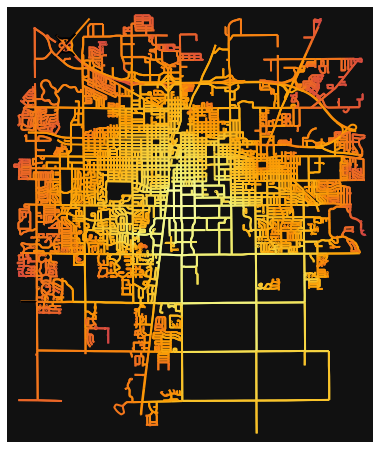

In [15]:
closeness_centrality = nx.closeness_centrality(nx.line_graph(G_bb))
nx.set_edge_attributes(G_bb, closeness_centrality, 'closeness_centrality')

ec = ox.plot.get_edge_colors_by_attr(G_bb, 'closeness_centrality', cmap='inferno')
fig, ax = ox.plot_graph(G_bb, edge_color=ec, edge_linewidth=2, node_size=0)

<a id='path'></a>

### Shortest path

In [16]:
#Origin and Destination coordinates
origin = (40.092270, -88.276520)
destination = (40.110306, -88.238833)

#We need to snap them to the nearest node before calculating the path.
origin_node = ox.get_nearest_node(G_bb, origin)
destination_node = ox.get_nearest_node(G_bb, destination)

### Dijkstra

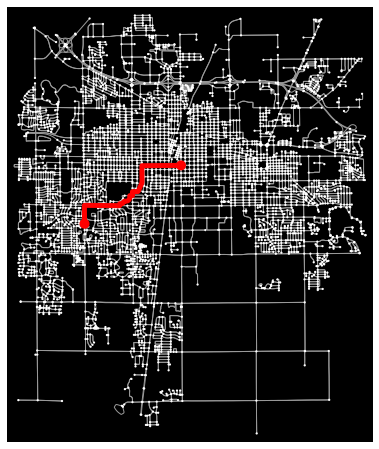

In [17]:
dijstra_route = nx.dijkstra_path(G_bb, origin_node, destination_node, weight="length")


fig, ax = ox.plot_graph_route(G_bb, dijstra_route, route_linewidth=5, 
                              node_size=5, bgcolor='k', route_alpha=1)

The shortest distance between the locations:

In [18]:
dijstra_route_length = nx.dijkstra_path_length(G_bb, origin_node, destination_node, weight="length")
dijstra_route_length

4946.118

### A*

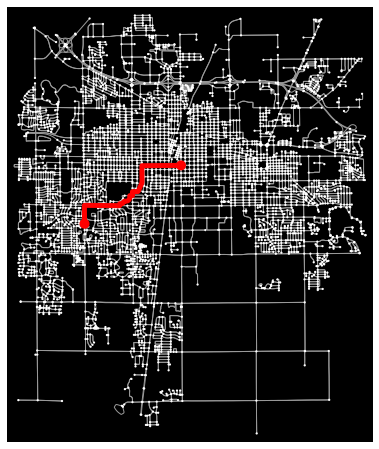

In [19]:
a_star_route = nx.astar_path(G_bb, origin_node, destination_node, weight="length")

fig, ax = ox.plot_graph_route(G_bb, a_star_route, route_linewidth=5, node_size=5, bgcolor='k', route_alpha=1)

In [20]:
A_star_route_length = nx.astar_path_length(G_bb, origin_node, destination_node, weight="length")

A_star_route_length

4946.118

You can find the A* and the Dijkstra algorithms return you the same route.

#### Previously we used the raw distance as the optimization criterion. Here how about we use travel time instead?

The speed limit data are included in the OSM data, so we can calculate the approximate travel time using the speed limit and the street length.

In [21]:
G_bb = ox.add_edge_speeds(G_bb)

# calculate travel time (seconds) for all edges
G_bb = ox.add_edge_travel_times(G_bb)


Below are the travel time for different types of roads. The unit is in km per hour.

In [22]:
# see mean speed/time values by road type
edges = ox.graph_to_gdfs(G_bb, nodes=False)
edges['highway'] = edges['highway'].astype(str)
edges.groupby('highway')[['length', 'speed_kph', 'travel_time']].mean().round(1)

,length,speed_kph,travel_time
highway,,,
"['motorway_link', 'motorway']",987.4,58.9,60.3
"['road', 'residential']",112.5,58.9,6.9
"['tertiary', 'residential']",141.6,47.4,10.8
"['tertiary', 'unclassified']",475.0,47.4,36.1
"['unclassified', 'residential']",613.7,48.3,45.7
junction,58.7,58.9,3.6
motorway,773.2,100.2,28.3
motorway_link,234.4,58.9,14.3
primary,159.1,58.0,9.7


Now we use the travel_time as the weight in the `nx.dijkstra_path()` function. Note that the path is different, here we travel along major roads: Mattis -> Kirby -> Neil. 

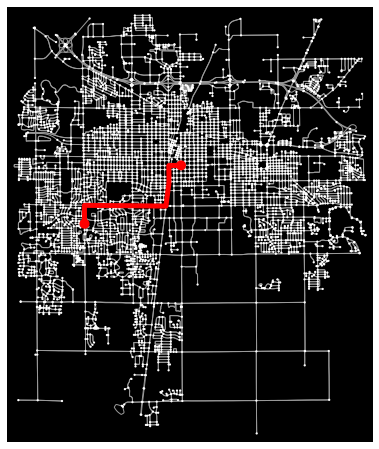

In [23]:
dijstra_route_time = nx.dijkstra_path(G_bb, origin_node, destination_node, weight="travel_time")

fig, ax = ox.plot_graph_route(G_bb, dijstra_route_time, route_linewidth=5, node_size=5, bgcolor='k', route_alpha=1)

The travel time: Here the unit is in seconds. It takes around 5.5 minutes (334 seconds) for me go from my apartment to campus, if I drive at the speed limit.

In [24]:
nx.dijkstra_path_length(G_bb, origin_node, destination_node, weight="travel_time")


334.80000000000007

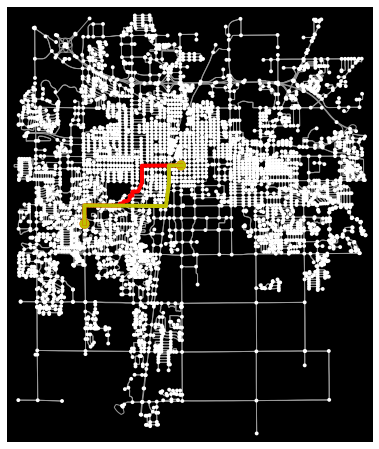

In [25]:
fig, ax = ox.plot_graph_routes(G_bb, routes=[dijstra_route,dijstra_route_time], route_colors=['r', 'y'], bgcolor='k', route_alpha=1)

We can compare the two maps, one using shortest distance, one using least travel time.

In [26]:
route_map = ox.plot_route_folium(G_bb, dijstra_route_time)
route_map

Plot the route as an interactive web map

In [27]:
route_map_st = ox.plot_route_folium(G_bb, dijstra_route_time, tiles="Stamen Toner")
route_map_st

<a id='sa'></a>
### Service area

`osmnx` can also help to calculate service areas on a network. In this example, let's look at Carle Hospital, and to see what is the area that has accessibility of 3, 5, 10, and 15 mintues.

In [28]:
carle = (40.116988, -88.215512)

center_node = ox.get_nearest_node(G_bb, carle)

In [29]:
from shapely.geometry import Point, LineString, Polygon
from descartes import PolygonPatch


trip_times = [3*60, 5*60, 10*60, 15*60] #in seconds

iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)

isochrone_polys = []


for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G_bb, center_node, radius=trip_time, distance='travel_time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

Here are the nodes in the street network that travel to Carle Hospital at 3, 5, 10, 15 minutes.

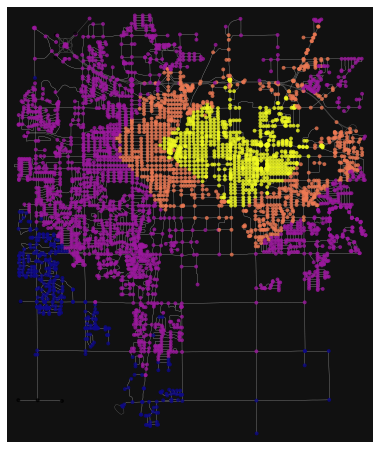

In [30]:
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G_bb, center_node, radius=trip_time, distance='travel_time')
    for node in subgraph.nodes():
        node_colors[node] = color
        
nc = [node_colors[node] if node in node_colors else 'none' for node in G_bb.nodes()]
#ns = [15 if node in node_colors else 0 for node in G_bb.nodes()]
fig, ax = ox.plot_graph(G_bb, node_color=nc, node_alpha=0.8,
                        edge_linewidth=0.2, edge_color='#999999')

You can make some generalization to the above map.

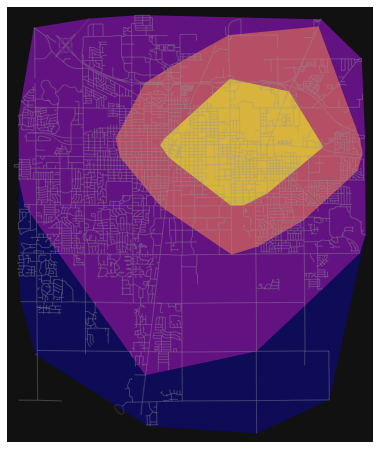

In [31]:
fig, ax = ox.plot_graph(G_bb, show=False, close=False, edge_color='#999999', edge_alpha=0.2, node_size=0)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
    
plt.show()